# Implement Callback Mechanism

In [1]:
import TensorFlow

struct DataBatch {
    // Simplifying assumption: Model inputs and outputs are Tensor<Float>
    var xb: Tensor<Float>
    var yb: Tensor<Float>
}

struct Data {
    // Simplifying assumption: Batches are in an array.
    var trainBatches: [DataBatch]
}

enum CallbackEvent {
    // I haven't implemented all the events.
    case beginFit
    case beginEpoch
    case beginBatch
    case afterForwardsBackwards
}

class Callback<Opt: Optimizer>
where Opt.Model.CotangentVector == Opt.Model.AllDifferentiableVariables,
      Opt.Model.Input == Tensor<Float>,
      Opt.Model.Output == Tensor<Float> {
    func apply(event: CallbackEvent, learner: Learner<Opt>) {}
}

class Learner<Opt: Optimizer>
where Opt.Model.CotangentVector == Opt.Model.AllDifferentiableVariables,
      Opt.Model.Input == Tensor<Float>,
      Opt.Model.Output == Tensor<Float>
{
    typealias Model = Opt.Model
    var model: Model
    
    // I'm getting some crashes in AD-generated code if I put a `lossFunc` in the learner.
    // So I'm putting a `lossWithGradient` for now, to work around this.
    // (model, context, inputs, labels) -> (loss, grad)
    typealias LossWithGradient = (Model, Context, Tensor<Float>, Tensor<Float>) -> (Tensor<Float>, Model.AllDifferentiableVariables)
    var lossWithGradient: LossWithGradient
    
    var optimizer: Opt
    var data: Data
    var callbacks: [Callback<Opt>]
    
    var loss: Tensor<Float> = Tensor(0)
    var grad: Model.AllDifferentiableVariables = Model.AllDifferentiableVariables.zero
    
    var epoch: Int = 0
    var epochs: Int = 0
    
    init(
        model: Model,
        lossWithGradient: @escaping LossWithGradient,
        optimizer: Opt,
        data: Data,
        callbacks: [Callback<Opt>]
    ) {
        self.model = model
        self.lossWithGradient = lossWithGradient
        self.optimizer = optimizer
        self.data = data
        self.callbacks = callbacks
    }
    
    func trainOneBatch(xb: Tensor<Float>, yb: Tensor<Float>) {
        runCallbacks(event: .beginBatch)
        let context = Context(learningPhase: .training)
        let (loss, grad) = lossWithGradient(model, context, xb, yb)
        self.loss = loss
        self.grad = grad
        runCallbacks(event: .afterForwardsBackwards)
        optimizer.update(&model.allDifferentiableVariables, along: self.grad)
    }
    
    func trainOneEpoch() {
        runCallbacks(event: .beginEpoch)
        for batch in self.data.trainBatches {
            trainOneBatch(xb: batch.xb, yb: batch.yb)
        }
    }

    func fit(epochs: Int) {
        // I haven't implemented validation.
        self.epochs = epochs
        runCallbacks(event: .beginFit)
        for epoch in 1...epochs {
            self.epoch = epoch
            trainOneEpoch()
        }
    }
    
    private func runCallbacks(event: CallbackEvent) {
        for callback in callbacks {
            callback.apply(event: event, learner: self)
        }
    }
}

# Implement some example callbacks

In [20]:
%include "EnableIPythonDisplay.swift"
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

class Recorder<Opt: Optimizer> : Callback<Opt>
// Hmm, this boilerplate is kind of annoying.
where Opt.Model.CotangentVector == Opt.Model.AllDifferentiableVariables,
      Opt.Model.Input == Tensor<Float>,
      Opt.Model.Output == Tensor<Float>,
      // Notice that we can add constraints so that this callback only works with certain types of learners.
      // Here, we require that the optimizer's scalar type is float so that `plt.plot` understands the
      // learning rate.
      Opt.Scalar == Float {
          
    var losses: [Float] = []
    var lrs: [Float] = []
          
    override func apply(event: CallbackEvent, learner: Learner<Opt>) {
        switch event {
        case .beginFit:
            losses = []
            lrs = []
        case .afterForwardsBackwards:
            losses.append(learner.loss.scalar!)
            lrs.append(learner.optimizer.learningRate)
        default: break
        }
    }
          
    func plotLosses() {
        plt.plot(losses)
    }
          
    func plotLrs() {
        plt.plot(lrs)
    }
}

In [21]:
class ParamScheduler<Opt: Optimizer, Param> : Callback<Opt>
// Hmm, this boilerplate is kind of annoying.
where Opt.Model.CotangentVector == Opt.Model.AllDifferentiableVariables,
      Opt.Model.Input == Tensor<Float>,
      Opt.Model.Output == Tensor<Float> {
    
    let paramKeyPath: ReferenceWritableKeyPath<Learner<Opt>, Param>
    let schedule: (Float) -> Param
    
    init(paramKeyPath: ReferenceWritableKeyPath<Learner<Opt>, Param>, schedule: @escaping (Float) -> Param) {
        self.paramKeyPath = paramKeyPath
        self.schedule = schedule
    }
          
    override func apply(event: CallbackEvent, learner: Learner<Opt>) {
        switch event {
        case .beginBatch:
            learner[keyPath: paramKeyPath] = schedule(Float(learner.epoch) / Float(learner.epochs))
        default: break
        }
    }
}

# A simple model and data

In [22]:
// Sum of the two inputs is the output.
let data = Data(trainBatches: [
    DataBatch(xb: [[0, 1], [2, 3]], yb: [[1], [5]]),
    DataBatch(xb: [[-3, 4], [-10, 2]], yb: [[1], [-8]]),
])

In [23]:
struct SillyModel : Layer {
    var dense: Dense<Float> = Dense(inputSize: 2, outputSize: 1)
    
    // A non-trained parameter to help illustrate the parameter scheduler.
    @noDerivative var sillyExtraBiasParam: Float = 0
    
    @differentiable
    func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        return dense.applied(to: input, in: context) + sillyExtraBiasParam
    }
}

In [24]:
func lossWithGrad(model: SillyModel, in context: Context, inputs: Tensor<Float>, labels: Tensor<Float>) -> (Tensor<Float>, SillyModel.AllDifferentiableVariables) {
    return model.valueWithGradient { model -> Tensor<Float> in
        let predictions = model.applied(to: inputs, in: context)
        return (predictions - labels).squared().mean()
    }
}

In [25]:
let model = SillyModel()

# Run the learner

In [26]:
// Some typealiases to reduce repeatedly typing types.
typealias MyOptimizer = SGD<SillyModel, Float>
typealias MyLearner = Learner<MyOptimizer>

In [27]:
let optimizer = MyOptimizer(learningRate: 0.01)

In [28]:
// We can't schedule the learning rate because the Optimizer protocol doesn't allow setting learning rates.
// If we change it to allow setting learning rates, `ParamScheduler` should allow setting learning rates,
// with `paramKeyPath: \MyLearner.optimizer.learningRate`.
let scheduler = ParamScheduler(paramKeyPath: \MyLearner.model.sillyExtraBiasParam) { t in
    if t < 0.5 {
        return -10
    } else {
        return 0
    }
}

In [29]:
let recorder = Recorder<MyOptimizer>()

In [30]:
let learner = Learner(
    model: model,
    lossWithGradient: lossWithGrad,
    optimizer: optimizer,
    data: data,
    callbacks: [
        recorder,
        scheduler
    ])

In [31]:
learner.fit(epochs: 100)

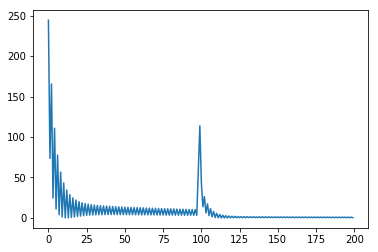

None


In [32]:
recorder.plotLosses()
plt.show()